In [358]:
import torch
from torch import nn
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## Цель:
- Обучите шум, который при добавлении к оригинальной картинке, заставит её ошибаться в пользу другого класса

## Dataset

### MNIST

In [12]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

In [13]:
train_dataset = tv.datasets.MNIST('.', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=transforms, download=True)

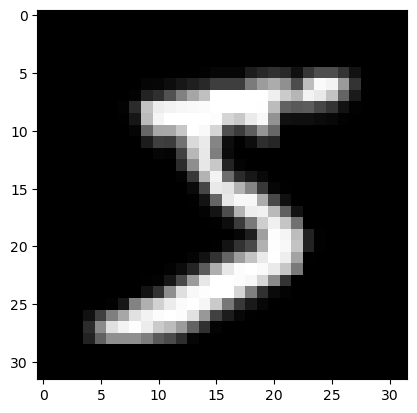

In [14]:
plt.imshow(train_dataset[0][0].numpy().reshape(32,32), cmap='gray');

## Model

### LeNet

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

## Learning

In [20]:
class param:
    bs = 256
    num_workers = 2
    lr = 0.01
    epochs = 5

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_ld = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=param.bs,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
#     num_workers=param.num_workers
)
test_ld = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=param.bs,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
#      num_workers=param.num_workers
)

model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=param.lr)

In [31]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n


def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    
        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}')

In [30]:
train(model, train_ld, test_ld, optim, param.epochs, device)

epoch 1, loss 0.0011, train acc 0.915, test acc 0.920
epoch 2, loss 0.0011, train acc 0.918, test acc 0.922
epoch 3, loss 0.0011, train acc 0.920, test acc 0.924
epoch 4, loss 0.0010, train acc 0.923, test acc 0.926
epoch 5, loss 0.0010, train acc 0.925, test acc 0.927


## Example

Text(0.5, 1.0, 'class 7 probabilities 0.9970128536224365')

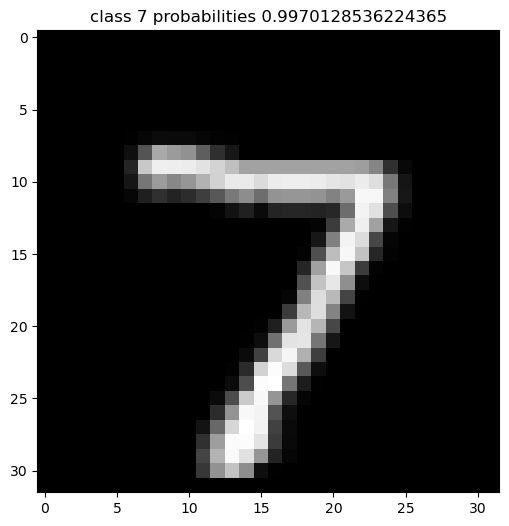

In [706]:
model.eval()
image, label = test_dataset[0]
predicted_lable = model(image.unsqueeze(0))
probabilities = torch.softmax(predicted_lable, dim=1)
predicted_class = torch.argmax(probabilities).item()
probabilities = probabilities[0][predicted_class].item()

plt.figure(figsize=(6, 6))
plt.imshow(image[0].detach().numpy(), cmap='gray')
plt.title(f'class {predicted_class} probabilities {probabilities}')

## Обучим шум, который при добавлении к оригинальной картинке, заставит её ошибаться в пользу другого класса
- так как в таком описании не совмем понятно нужен универсальный шум ко всему датасету или к конкрентной картинке, попробуем сделать два варианта

### Вариант 1. Шум к конкретной картинке
По примеру: [Adversarial Examples](https://www.cs.toronto.edu/~lczhang/321/lec/adv_notes.html)

In [560]:
target_class = torch.eye(10)[9]
# будем обучать шум, который будет делать предсказание в пользую цифры 9

In [592]:
def create_adversarial_example(model, image, target_class, num_steps):
    target_label = torch.argmax(target_class).item()
    image, label = image
    target_class = target_class.unsqueeze(0)
    noise = torch.zeros(1, 32, 32)
    noise.requires_grad = True

    optimizer = optim.SGD([noise], lr=0.01)
    criterion = nn.CrossEntropyLoss()

    i = 0
    for i in range(num_steps):
        adv_image = torch.clamp(image + noise, 0, 1)
        out = model(adv_image.unsqueeze(0))
        loss = criterion(out, target_class)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        adv_image = torch.clamp(image + noise, 0, 1).unsqueeze(0)
        adv_label = torch.argmax(model(adv_image), dim=1).item()
        if adv_label==target_label:
            break
        
    adv_image = torch.clamp(image + noise, 0, 1).unsqueeze(0)
    adv_label = torch.argmax(model(adv_image), dim=1).item()
    adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

    plt.subplot(1, 3, 1)
    plt.title(f"Original {label}")
    plt.imshow(image[0])
    
    plt.subplot(1, 3, 2)
    plt.title(f"Noise (iter {i})")
    plt.imshow(noise[0].detach().numpy())
    
    plt.subplot(1, 3, 3)
    plt.title("Adv label=%d P(Target label=%d)=%.2f" % (adv_label, target_label, adv_percent))
    plt.imshow(adv_image.squeeze(0).detach().numpy()[0])

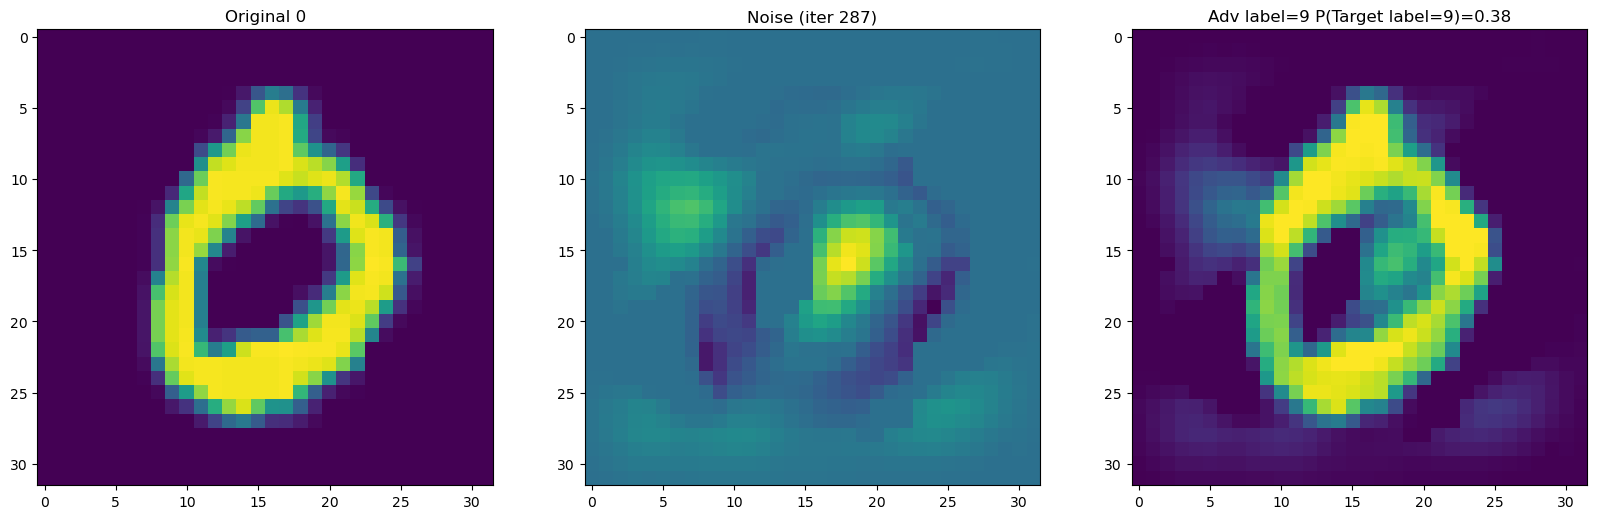

In [602]:
create_adversarial_example(model, test_dataset[3], target_class, num_steps=1000)

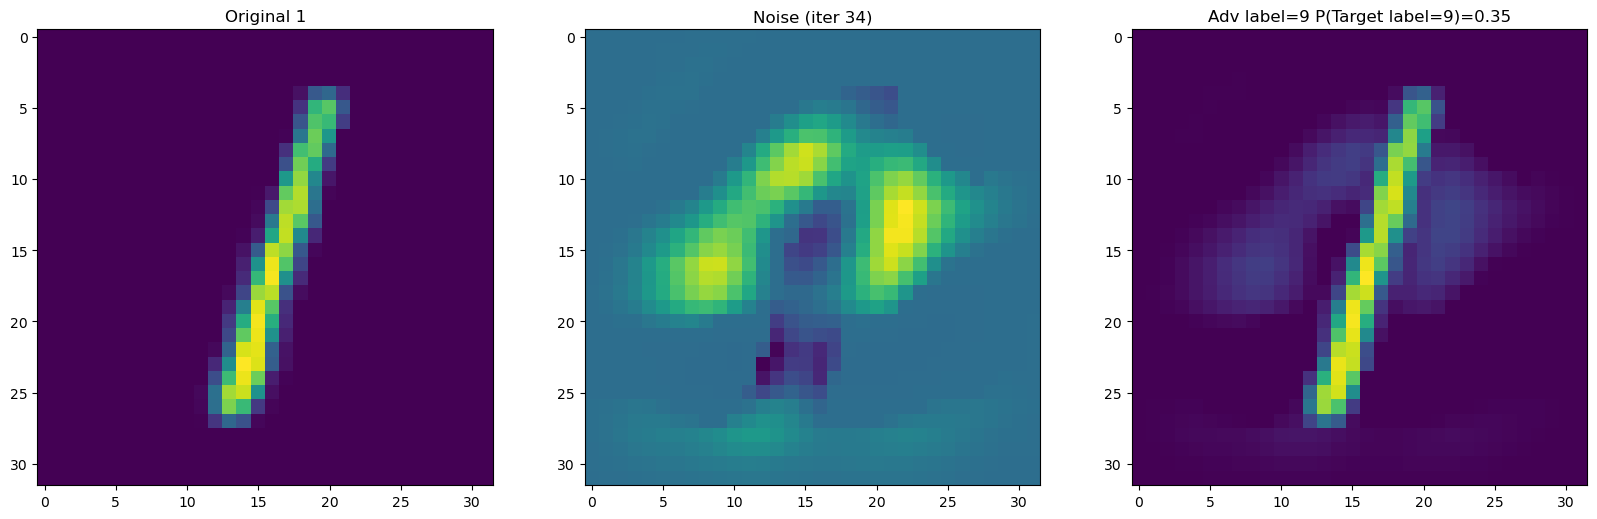

In [594]:
create_adversarial_example(model, test_dataset[2], target_class, num_steps=1000)

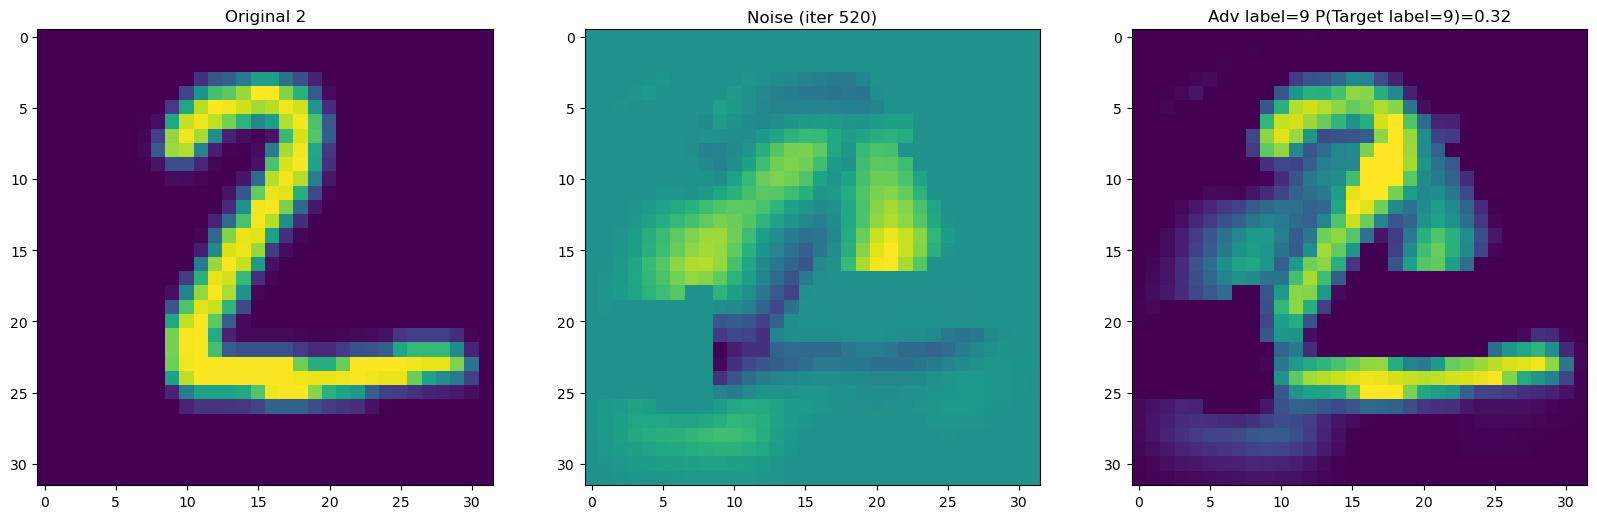

In [595]:
create_adversarial_example(model, test_dataset[1], target_class, num_steps=1000)

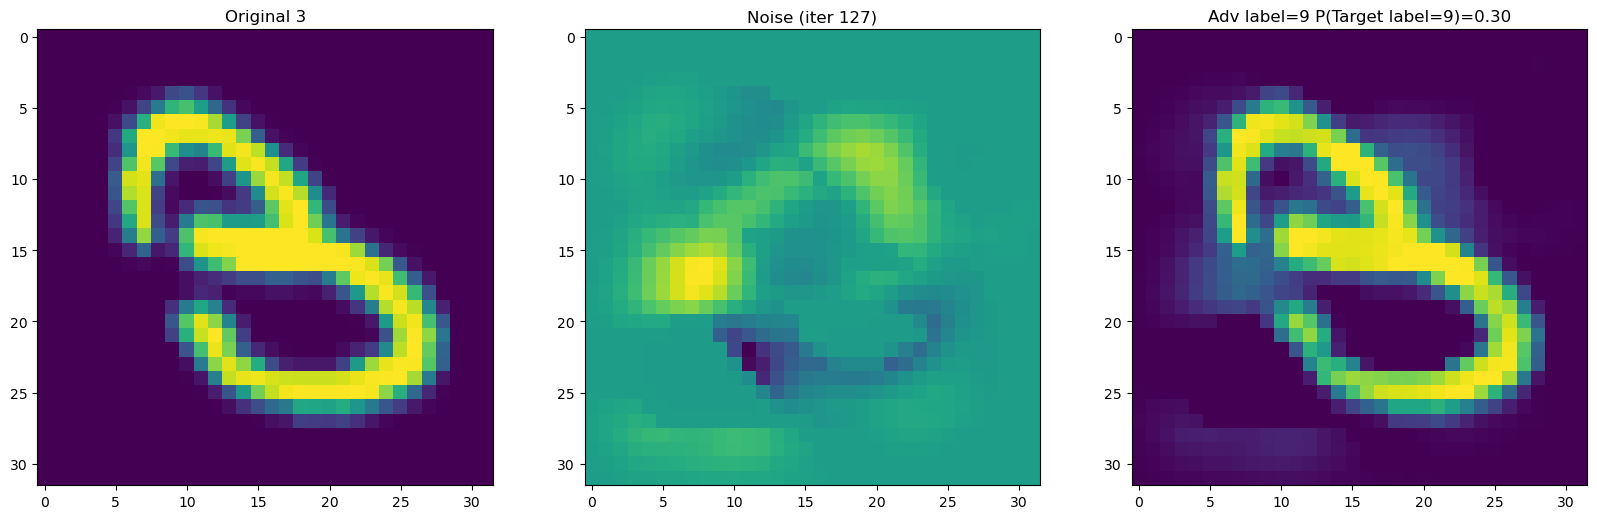

In [611]:
create_adversarial_example(model, test_dataset[18], target_class, num_steps=1000)

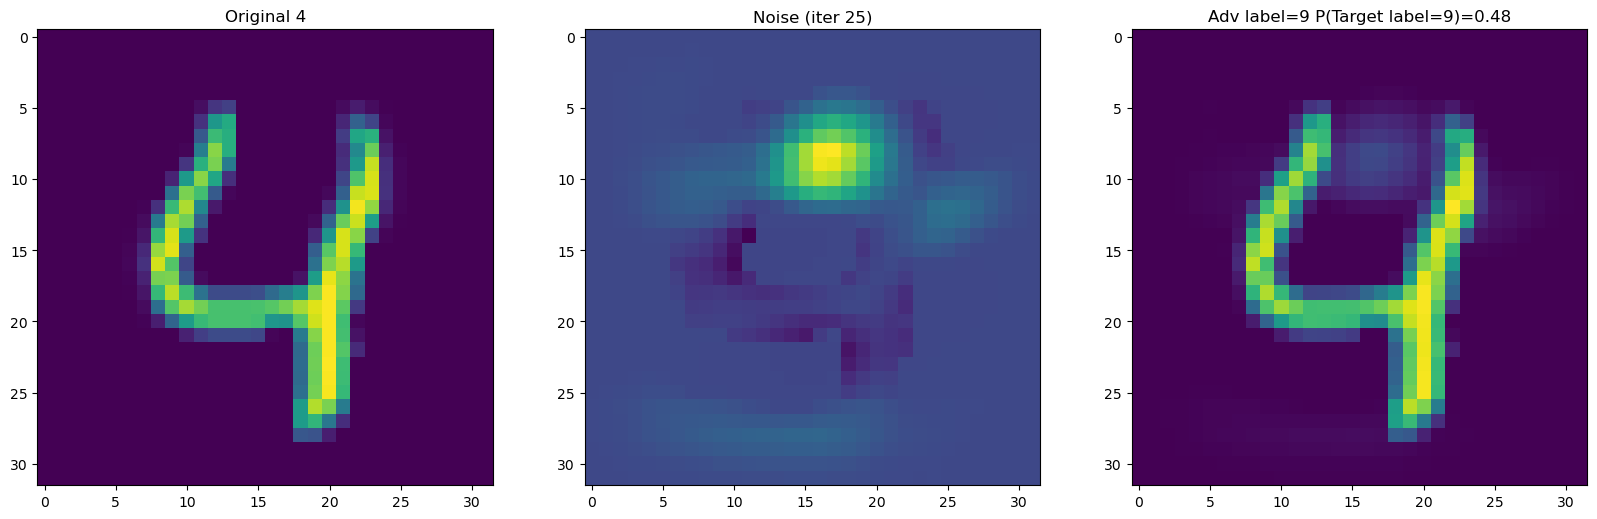

In [612]:
create_adversarial_example(model, test_dataset[4], target_class, num_steps=1000)

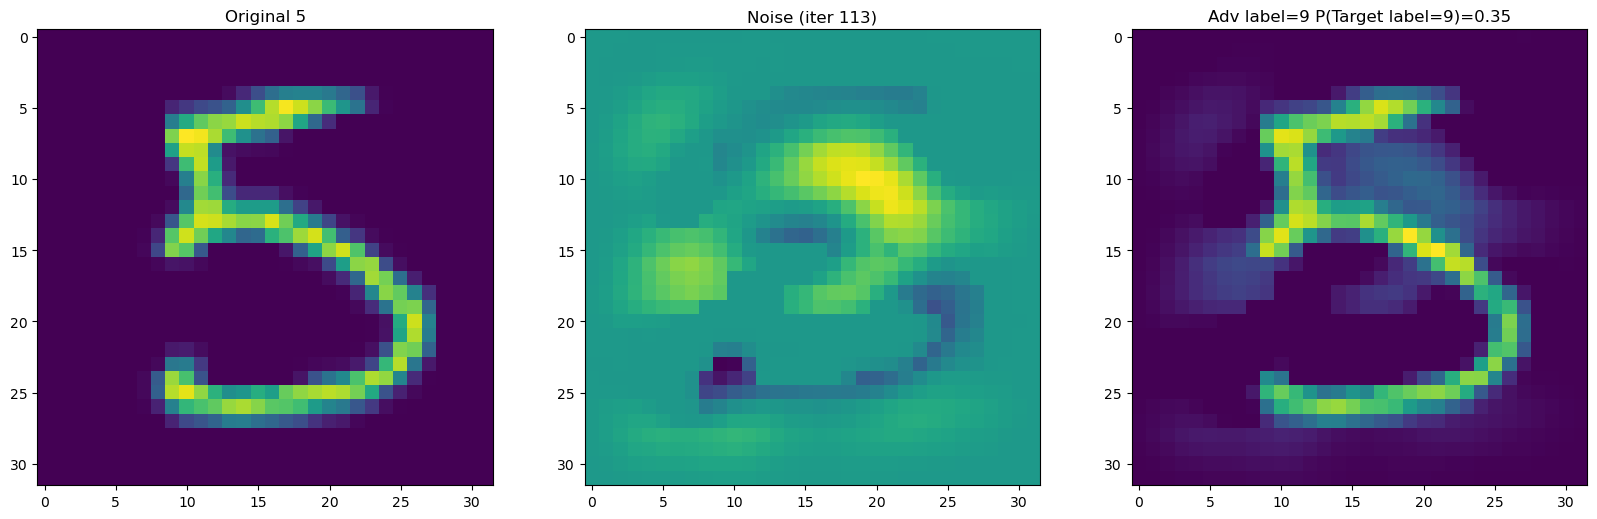

In [624]:
create_adversarial_example(model, test_dataset[15], target_class, num_steps=1000)

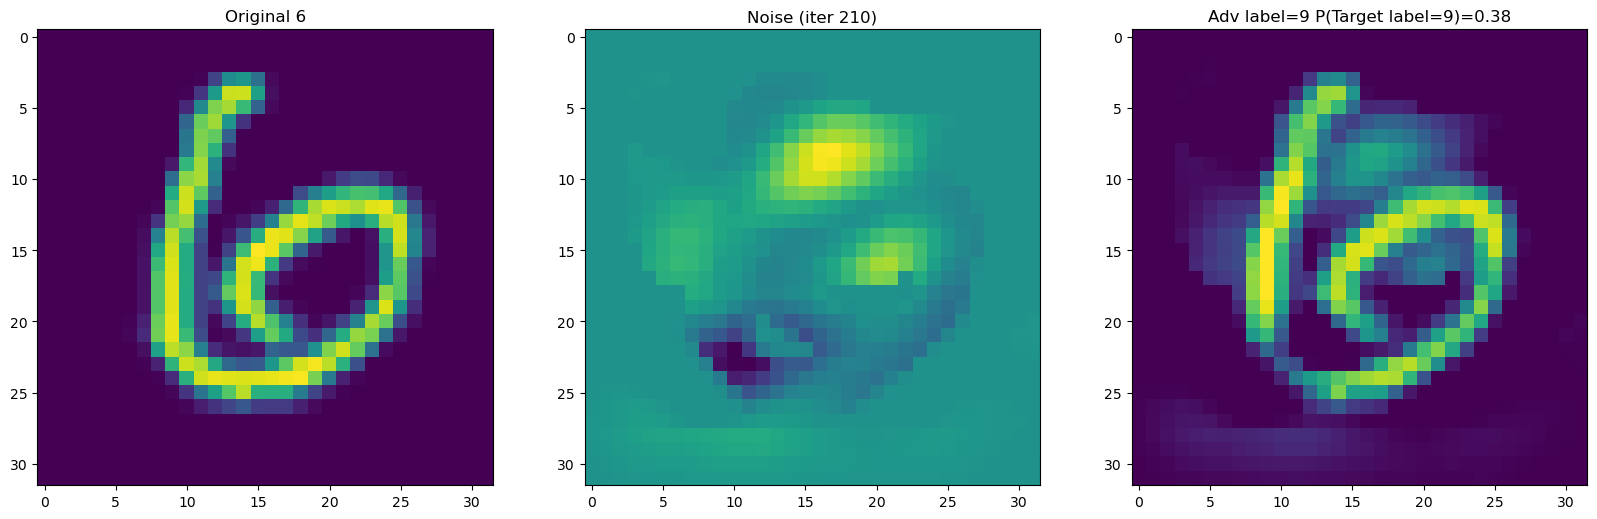

In [619]:
create_adversarial_example(model, test_dataset[11], target_class, num_steps=1000)

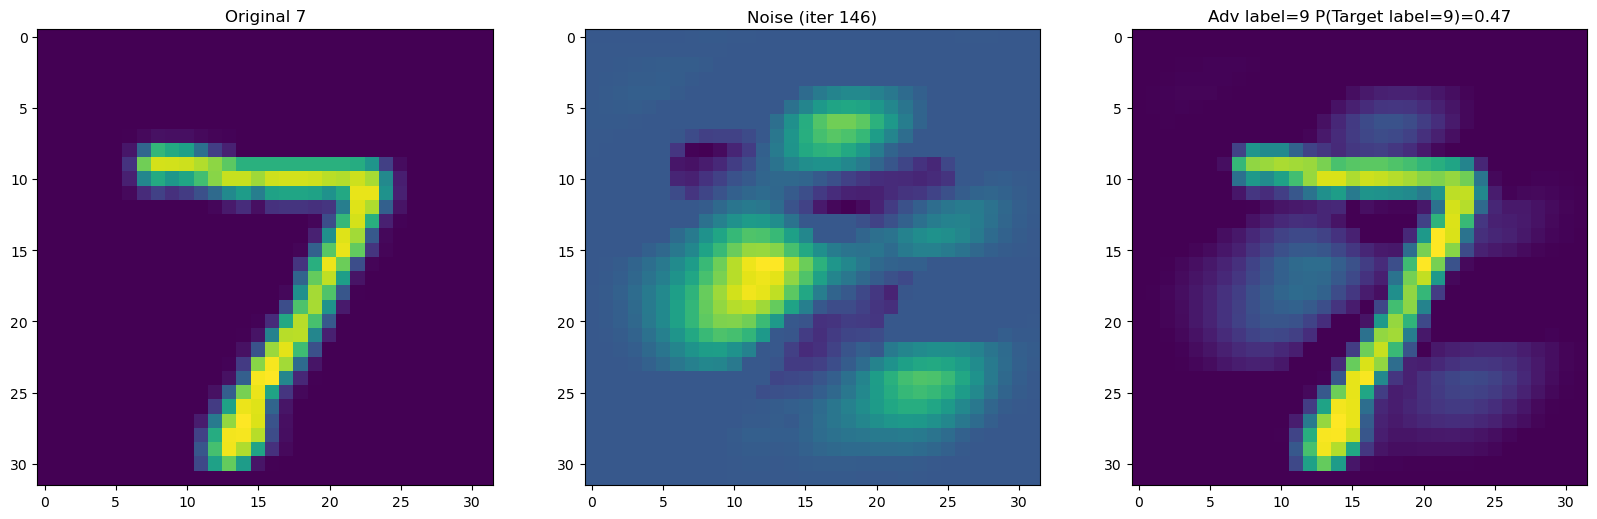

In [620]:
create_adversarial_example(model, test_dataset[0], target_class, num_steps=1000)

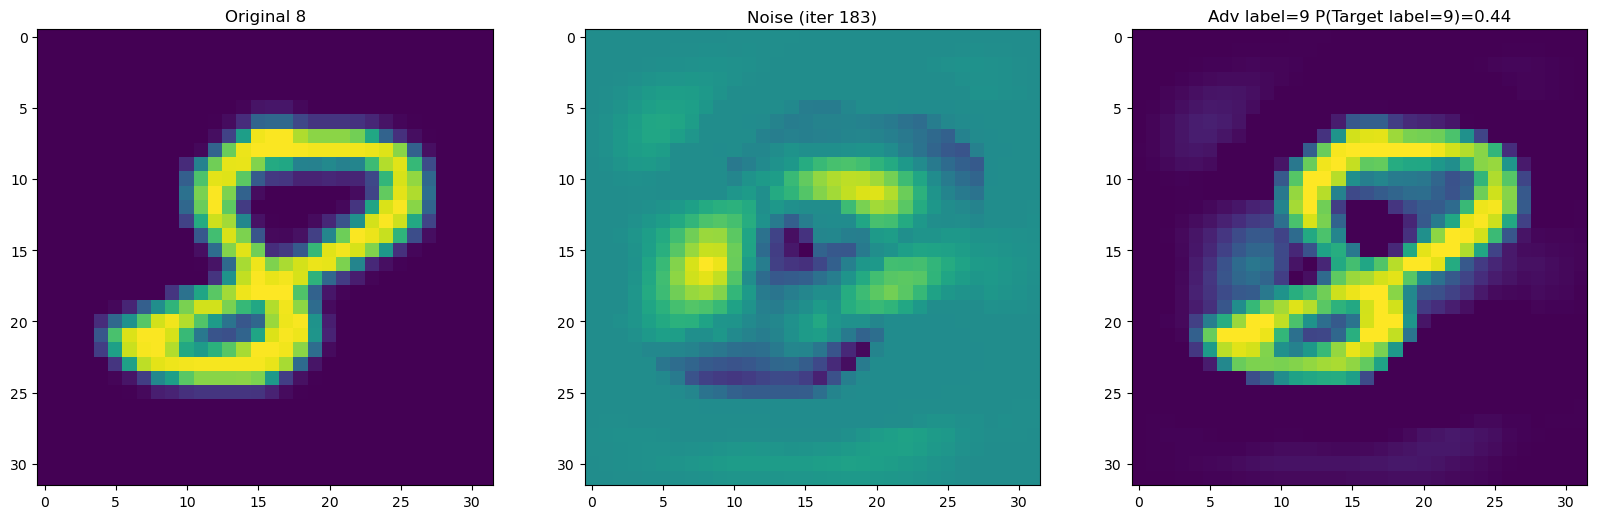

In [669]:
create_adversarial_example(model, test_dataset[61], target_class, num_steps=1000)

### Вариант 2. Универсальный шум ко всему датасету

In [671]:
def train_noise(model, train_loader, optimizer, criterion, noise, num_steps, target_class):
    model.eval()
    for i in range(num_steps):
        for batch_idx, (data, target) in enumerate(train_loader):
            target = target_class.expand(target.size(0), -1)
            optimizer.zero_grad()
            perturbed_data = data + noise
            output = model(perturbed_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            noise.grad.data.zero_()
        print(f'Epoch [{i}/{num_steps}], Loss: {loss.item()}')

In [680]:
criterion = nn.CrossEntropyLoss()

image, label = train_dataset[0]
noise = torch.zeros_like(image, requires_grad=True)

optimizer = optim.SGD([noise], lr=0.1)
num_steps = 5
train_noise(model, train_ld, optimizer, criterion, noise, num_steps, target_class)

Epoch [0/5], Loss: 0.06324044615030289
Epoch [1/5], Loss: 0.018019938841462135
Epoch [2/5], Loss: 0.019544193521142006
Epoch [3/5], Loss: 0.015117737464606762
Epoch [4/5], Loss: 0.016706619411706924


In [681]:
def show_adv(model, image, target_class, noise):
    target_label = torch.argmax(target_class).item()
    image, label = image
    adv_image = torch.clamp(image + noise, 0, 1).unsqueeze(0)
    adv_label = torch.argmax(model(adv_image), dim=1).item()
    adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

    plt.subplot(1, 3, 1)
    plt.title(f"Original {label}")
    plt.imshow(image[0])
    
    plt.subplot(1, 3, 2)
    plt.title(f"Noise")
    plt.imshow(noise[0].detach().numpy())
    
    plt.subplot(1, 3, 3)
    plt.title("Adv label=%d P(Target label=%d)=%.2f" % (adv_label, target_label, adv_percent))
    plt.imshow(adv_image.squeeze(0).detach().numpy()[0])

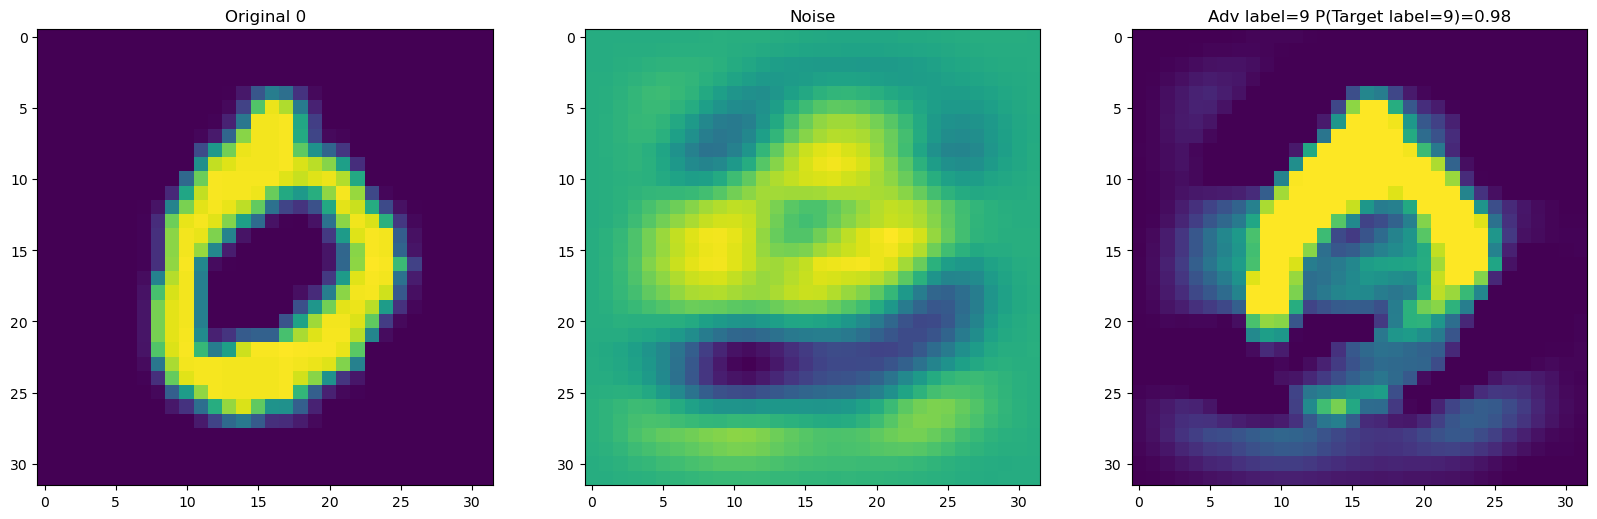

In [682]:
show_adv(model, test_dataset[3], target_class, noise)

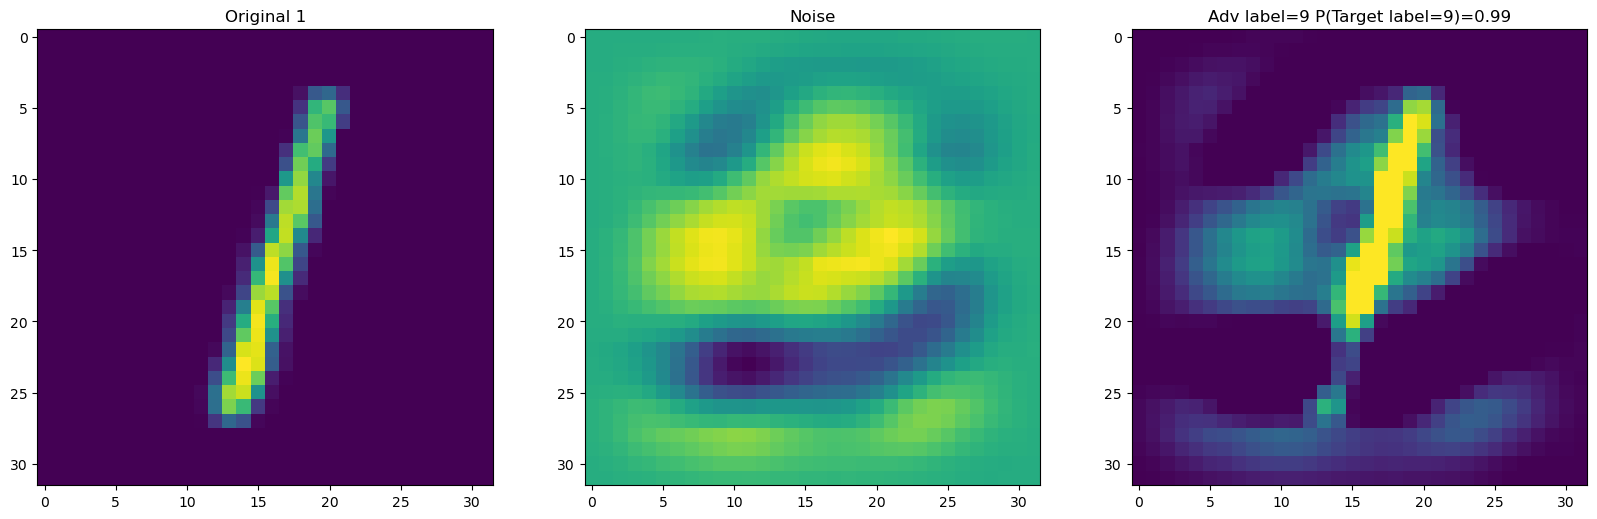

In [683]:
show_adv(model, test_dataset[2], target_class, noise)

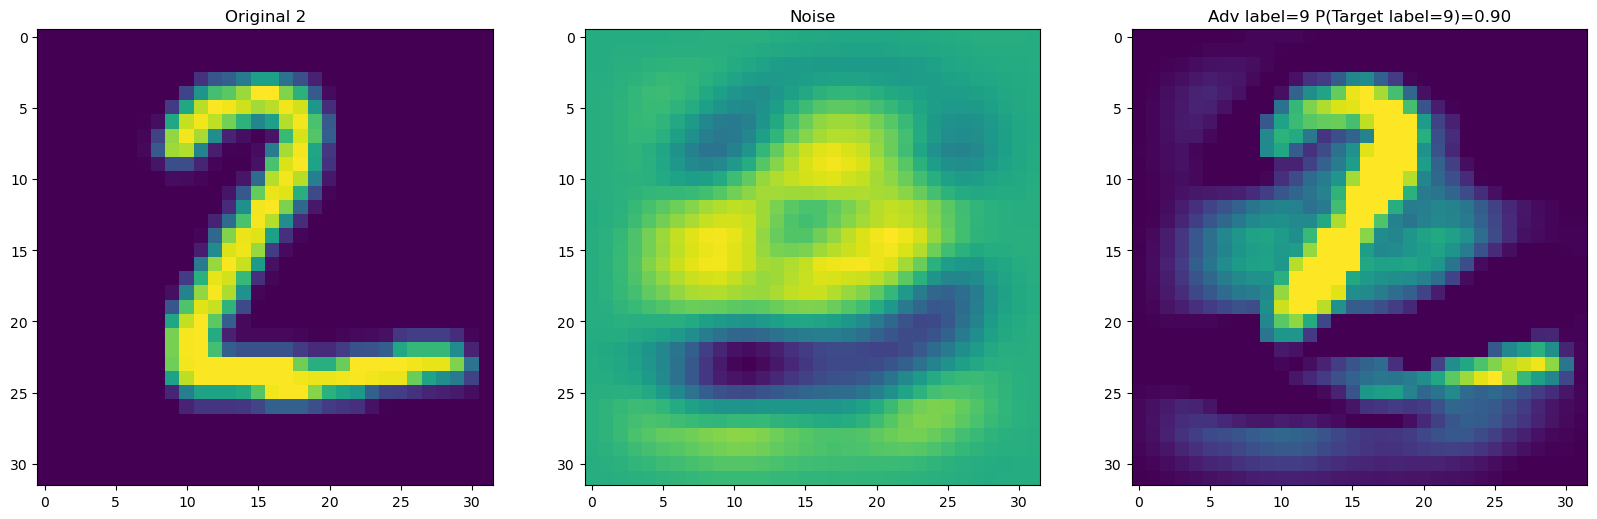

In [684]:
show_adv(model, test_dataset[1], target_class, noise)

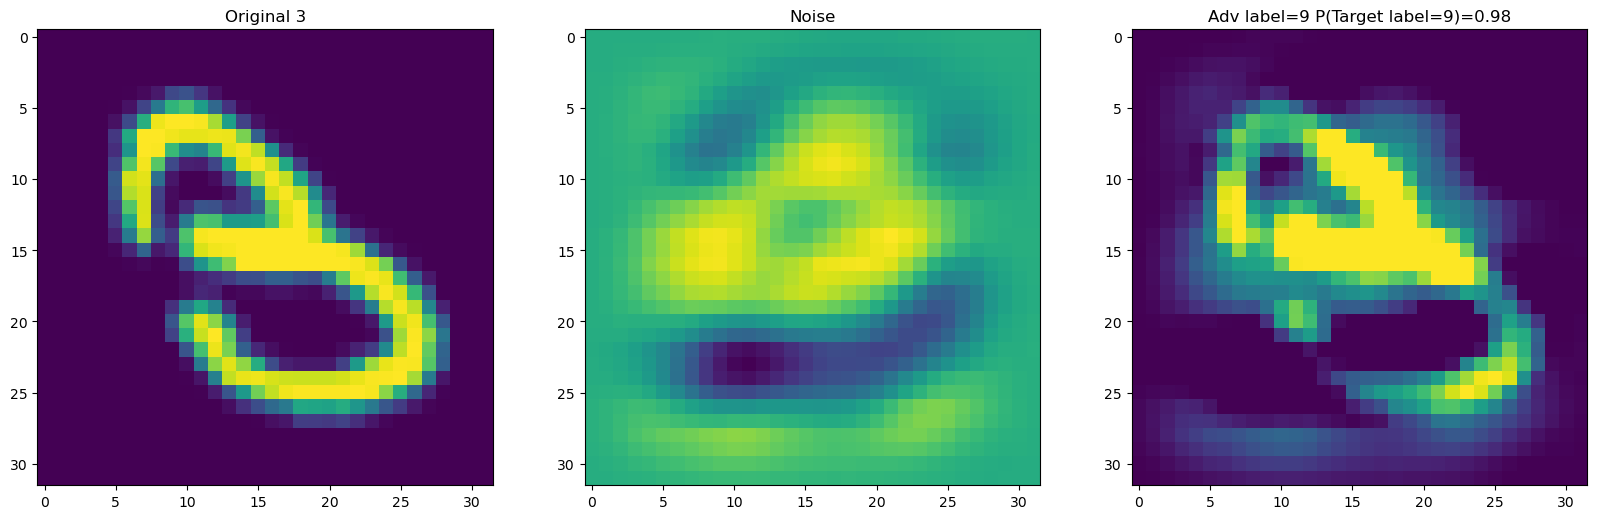

In [687]:
show_adv(model, test_dataset[18], target_class, noise)

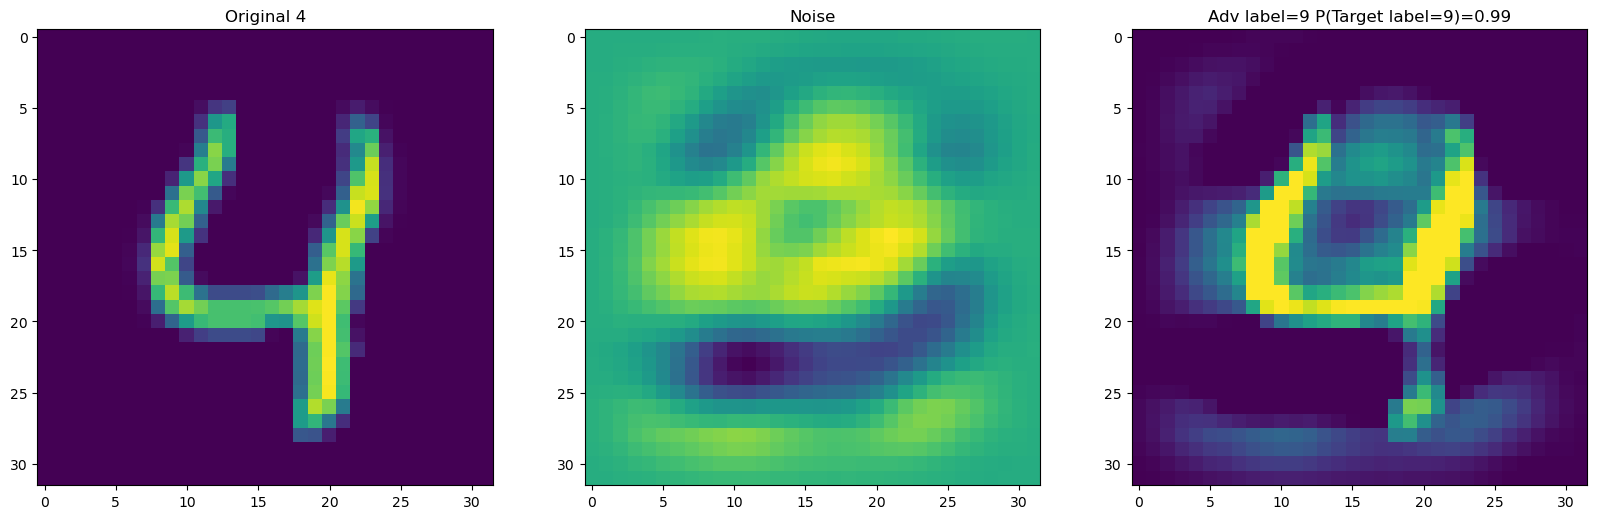

In [688]:
show_adv(model, test_dataset[4], target_class, noise)

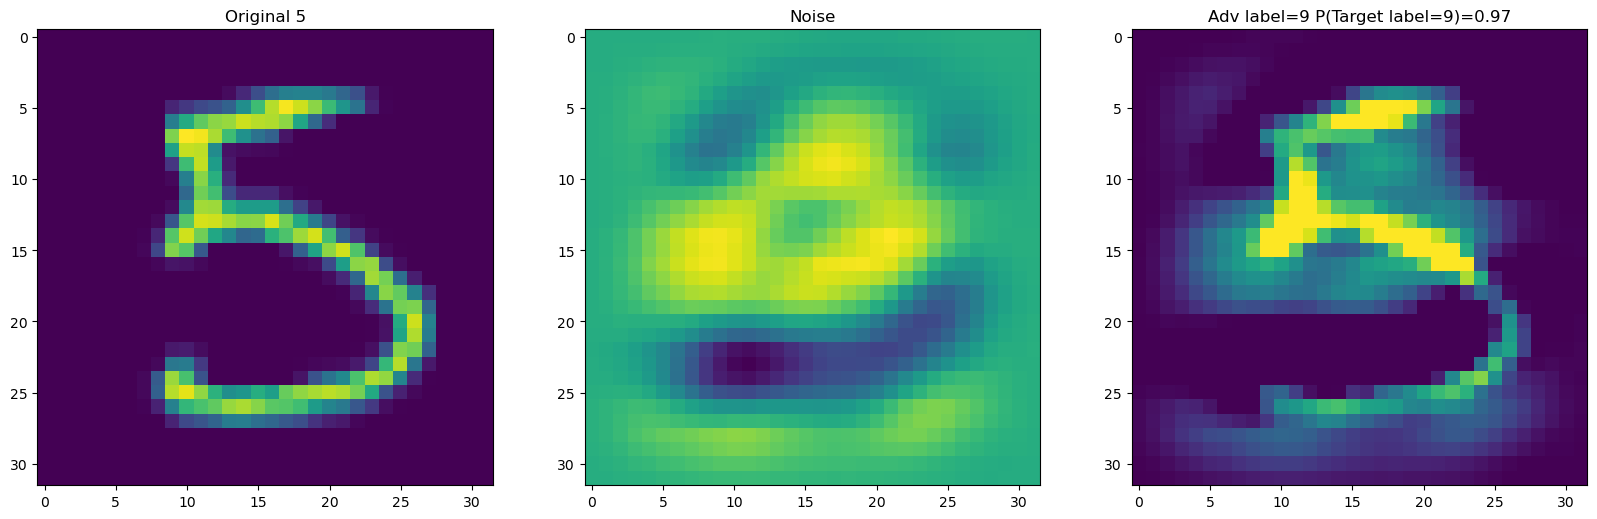

In [689]:
show_adv(model, test_dataset[15], target_class, noise)

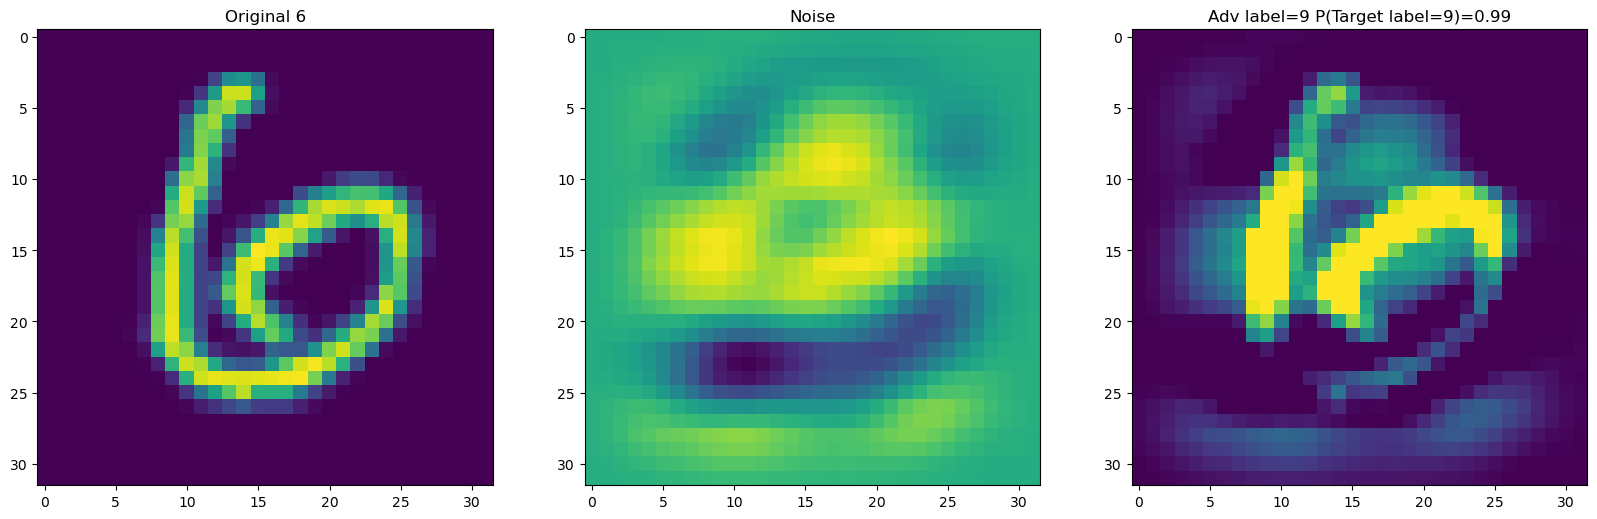

In [691]:
show_adv(model, test_dataset[11], target_class, noise)

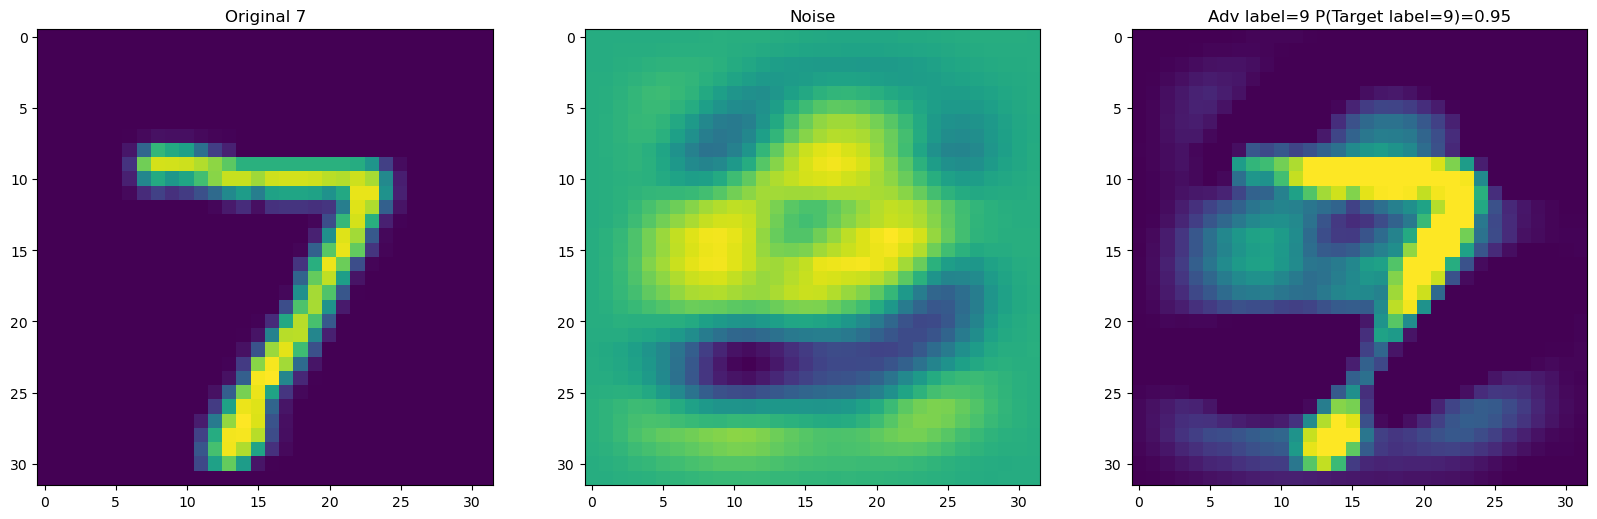

In [690]:
show_adv(model, test_dataset[0], target_class, noise)

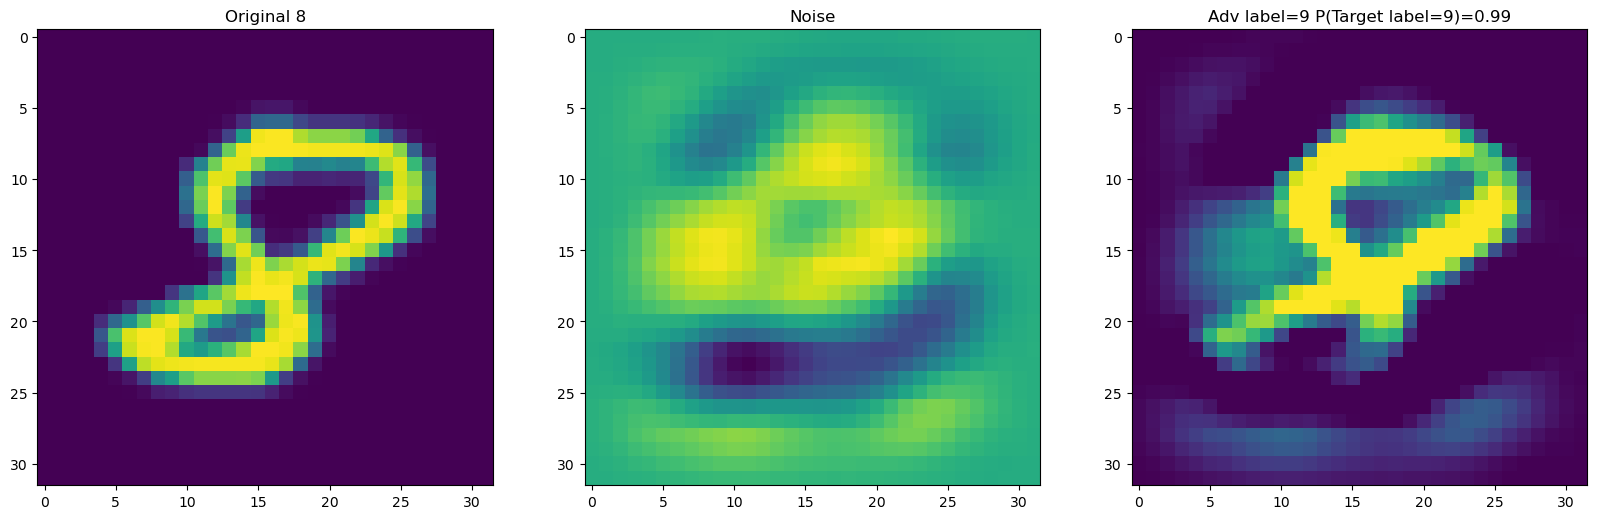

In [692]:
show_adv(model, test_dataset[61], target_class, noise)

## Выводы
- Шум к конкретной картинке выглядит более незаметнее
- Для цифры 9 шум быстрее получается в цифрах 1 (34 итерации) и 4 (25 итерации). Что логичнее, так как с этих цифр легче получить цифру 9
- Универсальный шум сильнее искажает картинку, но все равно можно понять какая какая там цифра в оригинале